Source 
http://mc-stan.org/users/documentation/case-studies/radon.html?fbclid=IwAR3h_03XtQnyJQ18EOdREkPX-4biDX7c5AN5e9DPQzQLZ6hB2JRFh1gHemQ
http://mc-stan.org/users/documentation/case-studies/tutorial_rstanarm.html

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('notebook')
import stanity

In [164]:
star = pd.read_csv('Star.csv', index_col=0, header = 0)

In [165]:
star.head()

,tmathssk,treadssk,classk,totexpk,sex,freelunk,race,schidkn
2,473,447,small.class,7,girl,no,white,63
3,536,450,small.class,21,girl,no,black,20
5,463,439,regular.with.aide,0,boy,yes,black,19
11,559,448,regular,16,boy,no,white,69
12,489,447,small.class,5,boy,yes,white,79


In [166]:
len(np.unique(star.schidkn))

79

In [167]:
schools = star.schidkn.unique()

In [168]:
np.sort(schools)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80])

In [169]:
star.loc[star.schidkn>=78,'schidkn'] -= 1

In [170]:
schools = star.schidkn.unique()

In [171]:
df = pd.DataFrame()

In [172]:
for col in ['tmathssk', 'treadssk', 'totexpk', 'schidkn' ]:
    data = star.loc[:,col]
    df[col] = data
data = star.loc[:,['classk', 'sex', 'freelunk','race']]
df = df.merge(pd.get_dummies(data), left_index=True, right_index=True)

In [173]:
print(df.columns[[4, 6, 8]])
print(df.head())

Index(['classk_regular', 'classk_small.class', 'sex_girl'], dtype='object')
    tmathssk  treadssk  totexpk  schidkn  classk_regular  \
2        473       447        7       63               0   
3        536       450       21       20               0   
5        463       439        0       19               0   
11       559       448       16       69               1   
12       489       447        5       78               0   

    classk_regular.with.aide  classk_small.class  sex_boy  sex_girl  \
2                          0                   1        0         1   
3                          0                   1        0         1   
5                          1                   0        1         0   
11                         0                   0        1         0   
12                         0                   1        1         0   

    freelunk_no  freelunk_yes  race_black  race_other  race_white  
2             1             0           0           0           1  


In [174]:
df.drop(df.columns[[5, 7, 9, 12]], axis=1, inplace=True)

In [175]:
df.columns = ['math', 'reading', 'year_teaching', 'school','reg_class', 'sml_class', 'is_girl', 'free_lunch', 'black','white']

In [176]:
df.head()

,math,reading,year_teaching,school,reg_class,sml_class,is_girl,free_lunch,black,white
2,473,447,7,63,0,1,1,0,0,1
3,536,450,21,20,0,1,1,0,1,0
5,463,439,0,19,0,0,0,1,1,0
11,559,448,16,69,1,0,0,0,0,1
12,489,447,5,78,0,1,0,1,0,1


In [177]:
df.corr()['math'].sort_values()

free_lunch      -0.243111
black           -0.174493
reg_class       -0.036504
school           0.045439
sml_class        0.080078
is_girl          0.081041
year_teaching    0.096687
white            0.174968
reading          0.713549
math             1.000000
Name: math, dtype: float64

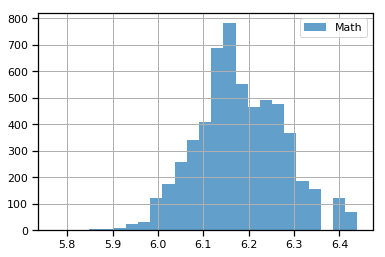

In [178]:
df.math.apply(lambda x:np.log(x)).hist(bins=25, alpha = 0.7, label = "Math") # Do we need to add +0.1?
plt.legend()
plt.show()


In [179]:
from sklearn.model_selection import train_test_split
labels = np.log(df.math)
df_train, df_test, y_train, y_test = train_test_split(df, labels, test_size = 0.25, random_state = 42)


## Pooled model 

In [72]:
pooled_code = """
data {
    int<lower=0>  N;
    int<lower=0> M;
    vector[N] x;
    vector[M] x_test;
    vector[N] y;
}
parameters {
    vector[2] beta;
    real<lower=0> sigma;
}
model {
    y ~ normal(beta[1] + beta[2]*x, sigma);
}
generated quantities{
    vector[N] log_lik;
    vector[M] y_pred_test;
    for (i in 1:M)
     y_pred_test[i] = normal_rng(beta[1] + beta[2]*x_test[i], sigma);
    for (i in 1:N)
     log_lik[i] = normal_lpdf(y[i]| beta[1] + beta[2]*x[i], sigma);
}

"""

In [73]:
import pystan

pool_data = {
    'N': df_train.shape[0], 
    'M': df_test.shape[0],
    'x': df_train.loc[:,'year_teaching'],
    'x_test': df_test.loc[:,'year_teaching'],
    'y': y_train,
}

In [74]:
pooled_fit = pystan.stan(model_code=pooled_code, data = pool_data, iter = 1000, chains = 2)
print(pooled_fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_174aac4ec68a4e0adc2676445f7b9556 NOW.
/opt/conda/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpnprzmppl/stanfit4anon_model_174aac4ec68a4e0adc2676445f7b9556_5589565190765515171.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Inference for Stan model: anon_model_174aac4ec68a4e0adc2676445f7b9556.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[1]             6.17  1.5e-4 2.8e-3   6.16   6.17   6.17   6.17   6.17    352    1.0
beta[2]           1.2e-3  1.3e-5 2.7e-4 6.9e-4 1.0e-3 1.2e-3 1.4e-3 1.8e-3    439    1.0
sigma                0.1  6.8e-5 1.0e-3   0.09    0.1    0.1    0.1    0.1    227   1.01
log_lik[1]          1.06  1.0e-3   0.02   1.02   1.05   1.06   1.08    1.1    372    1.0
log_lik[2]          1.41  6.9e-4   0.01   1.39   1.41   1.41   1.42   1.44    242   1.01
log_lik[3]          0.64  7.7e-4   0.02    0.6   0.62   0.64   0.65   0.68    787    1.0
log_lik[4]          1.41  6.9e-4   0.01   1.39    1.4   1.41   1.42   1.43    241   1.01
log_lik[5]          1.41  6.9e-4   0.01   1.39   1.41   1.41   1.42   1.43    237   1.01
log_lik[6]  

In [81]:
pooled_sample = pooled_fit.extract(permuted=True)

loglik = (pooled_sample["log_lik"])
psisloo = stanity.psisloo(loglik)
print("elpd_loo: ",psisloo.elpd)
#psisloo.plot()
lppd_pooled = 0 
for i in range (df_train.shape[0]):
    lppd_pooled = lppd_pooled + np.log(np.mean(np.exp(loglik[:,i])))

peff_pooled = np.sum(lppd_pooled) - psisloo.elpd
print(peff_pooled)

elpd_loo:  3965.5742856006655
3.142945585324469


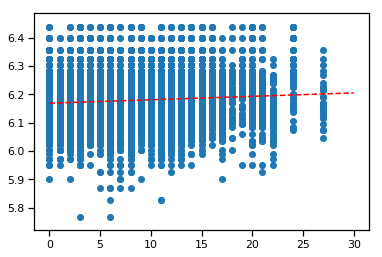

In [82]:
b0, m0 = pooled_sample['beta'].T.mean(1)
plt.scatter(df.year_teaching, np.log(df.math))
xvals = np.linspace(0,30)
plt.plot(xvals, m0*xvals+b0, 'r--')
plt.show()



In [108]:
#Comparing y_pred with y_test
MAE = np.sum(np.power(np.absolute(np.subtract(pooled_sample["y_pred_test"].mean(0), y_test)),2))
print(MAE)

13.908817818888808


##  Separate model

In [206]:
separate_code = """
data{
    int<lower=0> N;
    int<lower=1, upper=79> school[N]; #school indicator
    vector[N] x;
    vector[N] y;
}
parameters {
    vector[79] alpha;
    real beta; #only 1 beta, not a vector
    real<lower=0> sigma;
}
transformed parameters {
    vector[N] y_hat;  
    for (i in 1:N)
        y_hat[i] <- beta* x[i] + alpha[school[i]];
}
model {
    y ~ normal(y_hat, sigma);
}
generated quantities{
    vector[N] log_lik;
    for (i in 1:N)
     log_lik[i] = normal_lpdf(y[i]| y_hat[i], sigma);
}
"""

In [208]:
separate_data = {'N': df.shape[0],
                 'school': star.schidkn,
                 'x': df.loc[:,'year_teaching'],
                 'x_test': df.loc[:,'year_teaching'],
                 'y': np.log(df.math) }

In [209]:
separate_fit = pystan.stan(model_code = separate_code, data = separate_data, iter = 1000, chains = 2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0658457e53e8959415aa44ade4e33d07 NOW.
/opt/conda/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp4yceuqv_/stanfit4anon_model_0658457e53e8959415aa44ade4e33d07_2087898986742586174.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [210]:
print(separate_fit)
separate_sample = separate_fit.extract(permuted=True)


Inference for Stan model: anon_model_0658457e53e8959415aa44ade4e33d07.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[1]        6.19  3.2e-4   0.01   6.17   6.18   6.19   6.19   6.21   1182    1.0
alpha[2]         6.1  3.7e-4   0.01   6.07   6.09    6.1   6.11   6.12   1224    1.0
alpha[3]        6.19  2.8e-4 9.3e-3   6.17   6.18   6.19   6.19    6.2   1095    1.0
alpha[4]        6.14  2.9e-4   0.01   6.12   6.13   6.14   6.15   6.16   1490    1.0
alpha[5]        6.12  3.1e-4   0.01    6.1   6.11   6.12   6.13   6.14   1298    1.0
alpha[6]        6.14  3.1e-4   0.01   6.12   6.13   6.14   6.15   6.17   1463    1.0
alpha[7]        6.23  2.5e-4 8.7e-3   6.21   6.22   6.23   6.23   6.24   1250    1.0
alpha[8]        6.15  2.7e-4 9.2e-3   6.14   6.15   6.15   6.16   6.17   1145    1.0
alpha[9]        6.17  2.8e-4 8.8e-3   6.16   6.1

elpd_loo:  3965.5742856006655
-3956.9656711911543


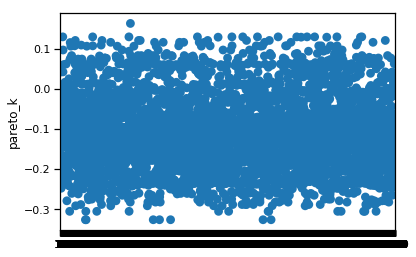

In [212]:
separate_sample = pooled_fit.extract(permuted=True)

loglik = (separate_sample["log_lik"])
psisloo = stanity.psisloo(loglik)
print("elpd_loo: ",psisloo.elpd)
psisloo.plot()
lppd_pooled = 0 
for i in range (df.shape[1]):
    lppd_pooled = lppd_pooled + np.log(np.mean(np.exp(loglik[:,i])))

peff_pooled = np.sum(lppd_pooled) - psisloo.elpd
print(peff_pooled)

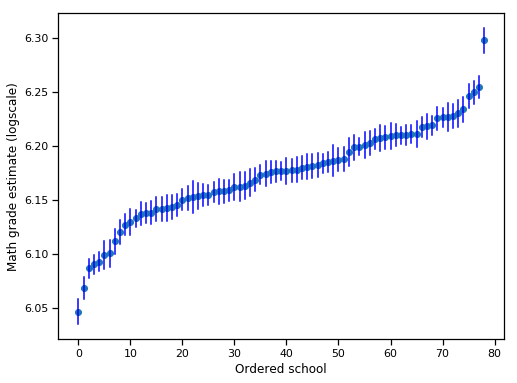

In [213]:
separate_sample = pd.Series(separate_fit['alpha'].mean(0), index=schools)
separate_sample_se = pd.Series(separate_fit['alpha'].std(0), index=schools)

order = separate_sample.sort_values().index
plt.figure(figsize = (8,6))
plt.scatter(range(len(separate_sample)), separate_sample[order])
for i, m, se in zip(range(len(separate_sample)), separate_sample[order], separate_sample_se[order]):
    plt.plot([i,i], [m-se, m+se], 'b-')
plt.ylabel('Math grade estimate (logscale)');plt.xlabel('Ordered school');